https://quantumcomputing.stackexchange.com/questions/35572/how-to-force-pymatching-into-the-opposite-equivalence-class

In [6]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import stim
import scienceplots
plt.style.use('science')
plt.rcParams['figure.dpi'] = 300
import matplotlib.colors as colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors.hex2color("#66c2a5"), colors.hex2color("#fc8d62"), colors.hex2color("#8da0cb"), colors.hex2color("#e78ac3"), colors.hex2color( "#a6d854")])
import pymatching
import networkx as nx
import itertools

from src.rotated_surface_code import RotatedCode
from src.graph_representation import get_torch_graph

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data

In [8]:
p = 0.1
d = 5
code = RotatedCode(d)

In [77]:
error = code.generate_error_chain(p)
eq_class = code.get_eq_class(error)
syndrome = code.get_syndrome(error)

In [78]:
def get_node_feature_matrix(syndrome):
    """
    Creates a node feature matrix of dimensions 
    (number_of_defects, number_of_node_features), where each row
    is the feature vector of a single node.
    The feature vector is defined as
    x = (X, Z, d_north, d_west)
        X: 1 if defect corresponds to a X stabilizer
        Z: 1 if defect corresponds to a Z stabilizer
        d_north: distance to north boundary, i.e. row index in syndrome matrix
        d_west: distance to west boundary, i.e. column index in syndrome matrix
    """

    # syndromes come in shape [x_coordinate, z_coordinate]
    # get the nonzero entries (node features):
    defect_inds = np.nonzero(syndrome)
    node_features = np.transpose(np.array(defect_inds))
    # find the stabilizer types (1: X, 3: Z):
    stabilizer_type = syndrome[defect_inds] == 1
    # add stabilizer type as new node feature ([1, 0]: X, [0, 1]: Z):
    stabilizer_type = stabilizer_type[:, np.newaxis]
    # [shot no., time, space, [stabilizer type]]:
    node_features = np.hstack((node_features, stabilizer_type, ~stabilizer_type)).astype(np.float32)
    # Get defects (non_zero entries), defect indices (indices of defects in flattened syndrome)
    # and defect_indices_tuple (indices in 2D syndrome) of the syndrome matrix
    
    return torch.from_numpy(node_features)

In [79]:
def get_edges(node_features):
    '''Creates edges between all nodes with supremum norm as edge weight'''
    num_nodes = node_features.shape[0]

    # Fully connected graph: Generate edge list
    edge_index = torch.combinations(torch.arange(num_nodes, dtype=torch.int64), r=2).T  # Unique pairs (u, v)
    # Duplicate each edge as (u, v) and (v, u)
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    # compute the distances between the nodes (start node - end node):
    x_dist = torch.abs(node_features[edge_index[1, :], 0] - 
                    node_features[edge_index[0, :], 0])

    y_dist = torch.abs(node_features[edge_index[1, :], 1] - 
                    node_features[edge_index[0, :], 1])

    # inverse square of the supremum norm between two nodes
    edge_attr = torch.maximum(y_dist, x_dist)
    edge_attr = 1 / edge_attr ** 2

    return edge_index, edge_attr.reshape(-1, 1)

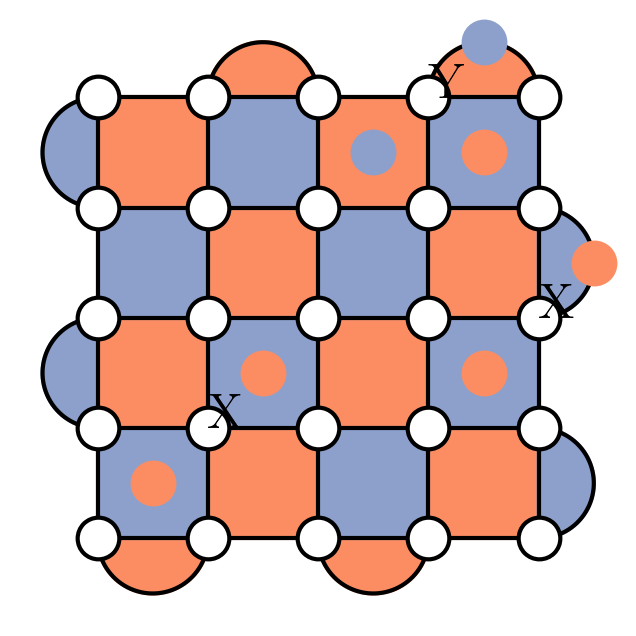

In [80]:
fig, ax = plt.subplots()
code.plot_syndrome(syndrome=syndrome, error=error, ax=ax)

In [81]:
node_features = get_node_feature_matrix(syndrome)

In [82]:
edge_index, edge_attr = get_edges(node_features)

In [84]:
model = EdgeWeightGNN()
model(node_features, edge_index, edge_attr)

(tensor([[0, 0, 1, 0, 1],
         [1, 2, 3, 4, 5]]),
 tensor([ 0.7098,  0.4975,  0.1693, -0.9146,  0.0436], grad_fn=<AddBackward0>),
 2,
 tensor([-0.3796, -0.2375, -0.3250, -3.7928, -0.4686], grad_fn=<SubBackward0>))

In [74]:
class EdgeWeightGNN(nn.Module):
    '''
    A Graph Neural Network (GNN) for predicting edge weights based on node features and edge embeddings.
    This model uses graph convolution layers (GCNs) for node feature transformation and an MLP for edge embedding
    to predict the edge weights, which are then sampled from a Gaussian distribution.

    Attributes:
        graph_conv_layers (nn.ModuleList): A list of GraphConv layers applied sequentially to update node features.
        edge_mlp (nn.Sequential): A multi-layer perceptron (MLP) for processing edge embeddings to predict edge weights.
        stddev (nn.Parameter): A learnable parameter representing the standard deviation of the Gaussian distribution for sampling.
    Args:
        node_feat_dim (int): The dimension of the input node features (e.g., feature size for each node).
        hidden_dim (int): The number of hidden units in each graph convolution layer.
        num_gcn_layers (int): The number of graph convolution layers to be stacked in the model.
        stddev (float): The standard deviation for the Gaussian distribution used to sample edge weights.
    '''

    def __init__(self, node_feat_dim = 4, hidden_dim = 8, num_gcn_layers = 2, stddev = 0.5):
        super(EdgeWeightGNN, self).__init__()

        # GCN layers
        self.graph_conv_layers = nn.ModuleList()
        self.graph_conv_layers.append(GraphConv(node_feat_dim, hidden_dim))
        for _ in range(num_gcn_layers - 1):
            self.graph_conv_layers.append(GraphConv(hidden_dim, hidden_dim))

        # Edge embedding MLP
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1))  # Output scalar edge weight

        # Standard deviation for the Gaussian (can be a learnable parameter or fixed)
        self.stddev = nn.Parameter(torch.tensor(stddev))
        
    def forward(self, x, edge_index, edge_weights):
        """
        Args:
            x (torch.Tensor): Node features of shape [num_nodes, node_feat_dim].
            edge_index (torch.Tensor): Edge indices of shape [2, num_edges].
            edge_weights (torch.Tensor): Edge features of shape [num_edges, 1].
        Returns:
            edge_weights (torch.Tensor): Predicted edge weights of shape [num_edges].
        """
        # store the stabilizer type of the nodes
        stabilizer_type = x[:, -2:]
        # Step 1: Apply GCN layers to update node embeddings
        for graph_conv in self.graph_conv_layers:
            x = F.relu(graph_conv(x, edge_index, edge_weights))

        # Step 2: Only keep X type stabilizers:
        x, edge_index, edge_weights = self.filter_nodes_and_edges(x, stabilizer_type, edge_index, edge_weights)

        # Step 3: Remove duplicates (need only to process (source, target)):
        edge_index, edge_weights = self.remove_duplicates(edge_index, edge_weights)
        
        # Step 4: Add boundary edges connecting each node to two virtual nodes
        edge_index, edge_weights, x, num_real_nodes = self.add_boundary_edges(
                                                    edge_index, edge_weights, x)
        
        # Step 5: Compute edge embeddings
        row, col = edge_index  # Separate the two nodes of each edge
        node_i = x[row]  # Node embeddings for source nodes
        node_j = x[col]  # Node embeddings for target nodes

        edge_embedding = torch.cat([node_i, node_j, edge_weights], dim=-1)  # [num_edges, 2 * hidden_dim + 1]

        # Step 6: Predict edge weight mean
        edge_weights_mean = self.edge_mlp(edge_embedding).squeeze(-1)  # [num_edges]
        # print("Mean of the edge weights:", edge_weights_mean)

        # Sample from the Gaussian distribution (mean, stddev)
        epsilon = torch.randn_like(edge_weights_mean)  # Standard normal noise
        sampled_edge_weights = edge_weights_mean + self.stddev * epsilon  # Sampled edge weights

        # Compute log-probabilities for the REINFORCE update
        log_probs = self.compute_log_probs(edge_weights_mean, sampled_edge_weights)
        
        return edge_index, sampled_edge_weights, num_real_nodes, log_probs
    
    def filter_nodes_and_edges(self, x, stabilizer_type, edge_index, edge_weights):
        """
        Removes nodes that are not of type [1, 0] (X stabilizers) and updates
        the edge index by re-numbering the nodes starting from 0, to n_X_nodes

        Args:
            x (torch.Tensor): Node features of shape [num_nodes, num_features].
            edge_index (torch.Tensor): Edge indices of shape [2, num_edges].
            edge_weights (torch.Tensor): Edge weights of shape [num_edges, 1].

        Returns:
            new_x (torch.Tensor): Filtered node features.
            new_edge_index (torch.Tensor): Updated edge indices.
            new_edge_weights (torch.Tensor): Updated edge weights.
        """
        # Step 1: Identify valid nodes (type [1, 0])
        valid_nodes = (stabilizer_type[:, 0] == 1) & (stabilizer_type[:, 1] == 0)

        # Step 2: Create a mapping from old node indices to new indices
        new_node_ids = torch.full((x.shape[0],), -1, dtype=torch.long)  # -1 for removed nodes
        new_node_ids[valid_nodes] = torch.arange(valid_nodes.sum())  # Renumber valid nodes

        # Step 3: Filter node features
        new_x = x[valid_nodes]  # Keep only valid nodes

        # Step 4: Filter edges where **both** nodes are valid
        src, tgt = edge_index
        valid_edges = valid_nodes[src] & valid_nodes[tgt]  # Ensure both endpoints are valid

        # Step 5: Update edge index with new node numbers
        new_edge_index = new_node_ids[edge_index[:, valid_edges]]  # Apply remapping
        new_edge_weights = edge_weights[valid_edges]  # Keep corresponding edge weights

        return new_x, new_edge_index, new_edge_weights

    
    def remove_duplicates(self, edge_index, edge_weights):
        """
        Removes duplicate undirected edges by keeping only (u, v) where u < v.
        Args:
            edge_index (torch.Tensor): Edge indices of shape [2, num_edges].
            edge_weights (torch.Tensor): Edge weights of shape [num_edges, 1].
        Returns:
            filtered_edge_index (torch.Tensor): Filtered edge indices.
            filtered_edge_weights (torch.Tensor): Corresponding edge weights.
        """
        mask = edge_index[0] < edge_index[1]  # Keep only edges where source < target
        filtered_edge_index = edge_index[:, mask]  # Apply mask to edge_index
        filtered_edge_weights = edge_weights[mask]  # Apply mask to edge_weight

        return filtered_edge_index, filtered_edge_weights
    
    def add_boundary_edges(self, edge_index, edge_weights, x):
        """
        Adds two unique boundary nodes for each real node:
            - One connecting to the left boundary (edge weight 1)
            - One connecting to the right boundary (edge weight 0)
        Args:
            x (torch.Tensor): Node features [num_nodes, feat_dim].
            edge_index (torch.Tensor): Edge indices [2, num_edges].
            edge_weights (torch.Tensor): Edge weights [num_edges, 1].
        Returns:
            edge_index (torch.Tensor): Updated edge indices with boundary edges.
            edge_weights (torch.Tensor): Updated edge weights.
            x (torch.Tensor): Updated node features including boundary nodes.
        Note: The virtual nodes on the western boundary have indices n, ... 2*n - 1
        """
        num_real_nodes = x.shape[0]

        # Create unique boundary node indices
        left_boundary_nodes = torch.arange(num_real_nodes, num_real_nodes * 2)  # Left boundary
        right_boundary_nodes = torch.arange(num_real_nodes * 2, num_real_nodes * 3)  # Right boundary

        # Create edges: (real_node -> left_boundary), (real_node -> right_boundary)
        left_edges = torch.stack([torch.arange(num_real_nodes), left_boundary_nodes], dim=0)
        right_edges = torch.stack([torch.arange(num_real_nodes), right_boundary_nodes], dim=0)

        # Assign weights: left boundary edge = 1, right boundary edge = 1
        left_weights = torch.ones((num_real_nodes, 1))  # Weight 1 for left boundary edges
        right_weights = torch.ones((num_real_nodes, 1))  # Weight 1 for right boundary edges

        # Extend node features for boundary nodes (copy features from corresponding real nodes)
        x_boundary = x  # Duplicate real node features for boundary nodes
        x = torch.cat([x, x_boundary, x_boundary], dim=0)  # Expand node embeddings

        # Concatenate new boundary edges and weights
        edge_index = torch.cat([edge_index, left_edges, right_edges], dim=1)
        edge_weights = torch.cat([edge_weights, left_weights, right_weights], dim=0)

        return edge_index, edge_weights, x, num_real_nodes


    def compute_log_probs(self, means, sampled_edge_weights):
        """
        Compute the log-probabilities of the sampled edge weights.
        This is based on the Gaussian distribution with the predicted mean and stddev.
        
        Args:
            means: The predicted means from the GNN.
            sampled_edge_weights: The sampled edge weights.

        Returns:
            log_probs: The log-probabilities of the sampled edge weights.
        """
        # Log probability of the sampled value under the Gaussian distribution
        log_probs = -0.5 * torch.log(2 * torch.pi * self.stddev**2) - (sampled_edge_weights - means)**2 / (2 * self.stddev**2)
        return log_probs


In [3]:
# Example graph parameters
num_nodes = 2
node_feat_dim = 5
hidden_dim = 8
num_gcn_layers = 2
stddev = 1.0

# Fully connected graph: Generate edge list
edge_index = torch.combinations(torch.arange(num_nodes), r=2).T  # Unique pairs (u, v)
# Duplicate each edge as (u, v) and (v, u)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
num_edges = edge_index.shape[1]
print(edge_index)
# Random input data
x = torch.randn((num_nodes, node_feat_dim))  # Node features
edge_attr = torch.randn((num_edges, 1))  # Random edge weights

# Initialize and forward pass
model = EdgeWeightGNN(node_feat_dim, hidden_dim, num_gcn_layers, stddev)
print("Old edge weights:", edge_attr.T)

edge_index, edge_weights, num_real_nodes, log_probs = model(x, edge_index, edge_attr)
print("Predicted edge weights:", edge_weights)


tensor([[0, 1],
        [1, 0]])
Old edge weights: tensor([[-0.5272, -2.4994]])
torch.Size([2, 8])
tensor([[0],
        [1]])
torch.Size([6, 8])
tensor([[0, 0, 1, 0, 1],
        [1, 2, 3, 4, 5]])
Predicted edge weights: tensor([ 0.8387,  0.4346, -0.7016, -1.6605,  0.2180], grad_fn=<AddBackward0>)


In [4]:
def train_gnn_with_rl_multi_sample(model, data, optimizer, num_epochs, num_samples, device):
    """
    Train the GNN with reinforcement learning (REINFORCE framework) using multiple samples
    to reduce the variance of the gradient estimate.

    Args:
        model: The GNN model (GCNEdgeWeightModel).
        data: The graph data (PyTorch Geometric Data object).
        optimizer: Optimizer (e.g., Adam) for the model.
        num_epochs: Number of training epochs.
        num_samples: Number of samples to draw per epoch.
        device: Device for computation (e.g., 'cuda' or 'cpu').
    """
    model.to(device)
    data.to(device)

    for epoch in range(num_epochs):
        model.train()
        
        all_log_probs = []
        all_rewards = []

        for _ in range(num_samples):  # Draw multiple samples per epoch
            # Forward pass: Get sampled edge weights and their log-probabilities
            edge_index, edge_weights, num_real_nodes, log_probs = model(data.x, data.edge_index, data.edge_attr)

            # Compute the reward for the current sample (interact with MWPM)
            reward = compute_mwpm_reward(edge_index, edge_weights, num_real_nodes, data.y)

            # Store log-probabilities and rewards
            all_log_probs.append(log_probs)
            all_rewards.append(reward)

        # Stack log-probs and rewards for averaging
        all_log_probs = torch.stack(all_log_probs, dim=0)  # Shape: (num_samples, num_edges)
        all_rewards = torch.stack(all_rewards, dim=0)      # Shape: (num_samples,)

        # Compute the REINFORCE loss
        # Average over the multiple samples
        mean_log_probs = torch.mean(all_log_probs, dim=0)  # Mean log-probs across samples
        mean_rewards = torch.mean(all_rewards, dim=0)      # Mean rewards across samples
        loss = -torch.mean(mean_log_probs * mean_rewards)  # Policy gradient loss

        # Backpropagate and update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Mean Reward: {mean_rewards.item():.4f}')

In [5]:
# Example graph data (you can replace this with your actual graph data)
num_nodes = 3
x = torch.randn((num_nodes, node_feat_dim))  # Node features
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2], 
                           [1, 2, 0, 2, 0, 1]])  # Edge list (2, num_edges)
edge_attr = torch.randn((edge_index.size(1), 1))  # Edge attributes
y = np.zeros(1)
# Create a Data object for PyTorch Geometric
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y = y)

# Instantiate the model and optimizer
stddev = 0.1
model = EdgeWeightGNN(node_feat_dim, hidden_dim, num_gcn_layers, stddev)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model with reinforcement learning (10 samples per epoch)
train_gnn_with_rl_multi_sample(model, data, optimizer, num_epochs=100, num_samples=10, device=device)

torch.Size([3, 8])
tensor([[0, 0, 1],
        [1, 2, 2]])
torch.Size([9, 8])
tensor([[0, 0, 1, 0, 1, 2, 0, 1, 2],
        [1, 2, 2, 3, 4, 5, 6, 7, 8]])


NameError: name 'compute_mwpm_reward' is not defined

# MWPM feedback - match arbitrary syndrome graph 

In [9]:
def compute_mwpm_reward(edge_index, edge_weights, num_real_nodes, logical_class):
    """
    Computes the MWPM predictions and returns a reward signal based on the correctness of the correction.

    Args:
        edge_weights: The predicted edge weights from the GNN (tensor of size [num_edges]).
        Contains (directed) edges between all real nodes and one edge to both boundaries for
        each real node 
        logical_class: The logical state (0, 1)

    Returns:
        reward: A scalar reward (1 if the correction is correct, - 1 otherwise).
    """
    # Create an empty undirected graph
    G = nx.Graph()

    # Add edges with weights using a generator
    G.add_edges_from((u, v, {"weight": -w}) for u, v, w in zip(edge_index[0], edge_index[1], edge_weights))

    # add boundary nodes:
    num_boundary_nodes = 2 * num_real_nodes if num_real_nodes % 2 == 0 else 2 * num_real_nodes +1
    # boundary nodes (fully connected)
    boundary_nodes = np.arange(num_real_nodes, num_boundary_nodes)  
    # Add edges of weight 0 between all pairs of boundary nodes
    G.add_edges_from((u, v, {"weight": 0}) for u, v in itertools.combinations(boundary_nodes, 2))


    # do the MWPM:
    matching = nx.algorithms.max_weight_matching(G, maxcardinality=True)
    print(matching)
    matching_array = np.array(list(matching))

    # Create boolean masks for the first and second sets
    mask_u_in_set1 = (matching_array[:, 0] >= 0) & (matching_array[:, 0] < num_real_nodes)
    mask_v_in_set2 = (matching_array[:, 1] >= num_real_nodes) & (matching_array[:, 1] < 2 * num_real_nodes)

    mask_v_in_set1 = (matching_array[:, 1] >= 0) & (matching_array[:, 1] < num_real_nodes)
    mask_u_in_set2 = (matching_array[:, 0] >= num_real_nodes) & (matching_array[:, 0] < 2 * num_real_nodes)

    # Combine both conditions: (u in set1 and v in set2) or (v in set1 and u in set2)
    valid_edges_mask = (mask_u_in_set1 & mask_v_in_set2) | (mask_v_in_set1 & mask_u_in_set2)

    # Count the edges running through the left boundary of the code:
    num_left_edges = np.sum(valid_edges_mask)
    
    # get the predicted logical state:
    predicted_state = num_real_nodes % 2

    # compare with logical state:
    correct_prediction = (predicted_state == logical_class)
    # Assign reward
    reward = 1 if correct_prediction else -1
    
    return torch.tensor(reward, dtype=torch.float32)

In [10]:
edge_index = np.array([[0, 0, 1, 0, 1], 
                       [1, 2, 3, 4, 5]])  # Edge list (2, num_edges)
edge_weights = np.array([5, 2, 1, 3, 5])
num_real_nodes = 2
logical_class = 1

compute_mwpm_reward(edge_index, edge_weights, num_real_nodes, logical_class)

{(3, 2), (0, 4), (1, 5)}


tensor(-1.)

[0 1]


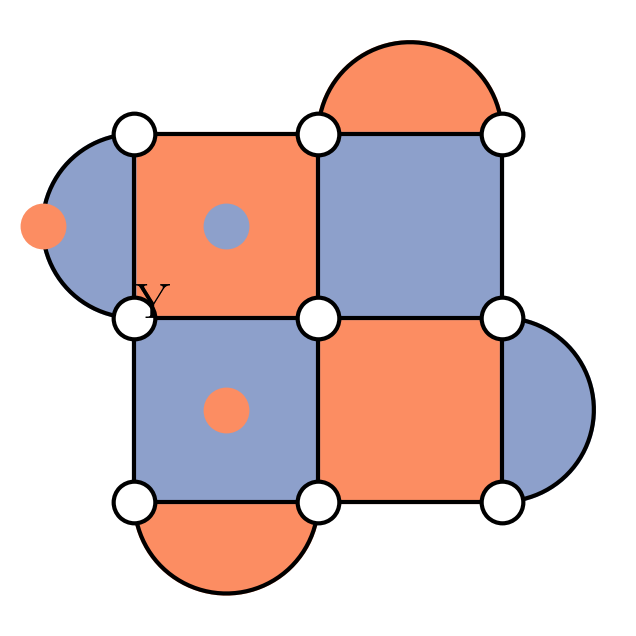

In [28]:
d = 3
code = RotatedCode(d)
error = code.generate_error_chain(0.1)
syndrome = code.get_syndrome(error)
logical_class = code.get_eq_class(error)
fig, ax = plt.subplots()
code.plot_syndrome(syndrome = syndrome, error = error, ax = ax)
print(logical_class)

# Circuit level noise using stim

In [47]:
circuit = stim.Circuit.generated("surface_code:rotated_memory_x",
                                        distance=3,
                                        rounds=1,
                                        after_clifford_depolarization=0,
                                        before_round_data_depolarization=0.01,
                                        after_reset_flip_probability=0,
                                        before_measure_flip_probability=0)

In [ ]:
model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
matching.draw()

In [ ]:
model.diagram("matchgraph-3d")

In [ ]:
matcher = pymatching.Matching.from_detector_error_model(model)
matcher.draw()

In [ ]:
matcher.edges()

# Old stuff

In [ ]:
error_chain = code.generate_error_chain(p)
error_chain = np.array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])
# error_chain = np.ones_like(error_chain)
syndrome = code.get_syndrome_string(error_chain)
s = np.concatenate((syndrome[0], syndrome[1]))

# Determine the syndrome consistent with the error
syndrome = code.get_syndrome(error_chain)
# Determine the equivalence class of the error chain
true_eq_class = code.get_eq_class(error_chain)
correction = code.get_MWPM_correction(error_chain)
fig, axs = plt.subplots(1, 2)
code.plot_syndrome(syndrome, error_chain, ax=axs[0], fig=fig)
code.plot_syndrome(syndrome, correction, ax=axs[1], fig=fig)
matcher.decode_to_edges_array(s)


In [27]:
s = np.concatenate((syndrome[0], syndrome[1]))

In [ ]:
correction = code.get_MWPM_correction(error_chain)
print(np.array_equal(true_eq_class, code.get_eq_class(correction)))
fig, axs = plt.subplots(1, 2)
code.plot_syndrome(syndrome, error_chain, ax=axs[0], fig=fig)
code.plot_syndrome(syndrome, correction, ax=axs[1], fig=fig)

In [29]:
circuit = stim.Circuit.generated(
                            "surface_code:rotated_memory_z",
                            rounds = 1,
                            distance = 5,
                            after_clifford_depolarization = 0,
                            after_reset_flip_probability = 0,
                            before_measure_flip_probability = 0,
                            before_round_data_depolarization = p)
detector_error_model = circuit.detector_error_model(decompose_errors=True)
matcher = pymatching.Matching.from_detector_error_model(detector_error_model)
sampler = circuit.compile_detector_sampler()
syndrome, actual_observables = sampler.sample(shots=1, separate_observables=True)

In [ ]:
s.shape

In [ ]:
syndrome.shape

In [ ]:
print(matcher.num_nodes)

In [ ]:
matcher.draw()

# Create matching graph with virtual nodes closest to each node

In [7]:
graph = get_torch_graph(syndrome, true_eq_class)

In [ ]:
error_chain

In [ ]:
note: maybe easiest to first generate graph, then add the virtual nodes after that?